Construccion de DAGS para proceso ETL en paralelo y carga en postgreSQL y AWS S3.
DAGS designing to setting up ETL process in paralel and loading into postgreSQL and AWS S3.

In [ ]:
# Descarga de Librerias y paquetes a utilizar
# Downloading of Libraries and dependencies

from airflow import DAG
from datetime import timedelta, datetime
from airflow.providers.http.sensors.http import HttpSensor
import json
from airflow.providers.http.operators.http import SimpleHttpOperator
from airflow.operators.python import PythonOperator
import pandas as pd
from airflow.operators.dummy_operator import DummyOperator
#from airflow.operators.EmptyOperator import DummyOperator
from airflow.utils.task_group import TaskGroup
from airflow.providers.postgres.operators.postgres import PostgresOperator
from airflow.providers.postgres.hooks.postgres import PostgresHook

In [5]:
# Descarga de modulo para ilustrar capturas del proyecto
# Module download to illustrate project's screenshots. 

from IPython.display import Image
%matplotlib inline

In [ ]:
# Transformacion de grados kelvin a grados centigrados
# Transformation from kelvin to celsious

def kelvin_a_Celcios(temp_in_kelvin):
    temp_en_Celcious = (temp_in_kelvin - 273.15)
    return round(temp_en_Celcious, 2)

In [ ]:
# Generacion de funcion para extraer las diferentes etiquetas que estan en formato JSON y grabarlos como CSV.
# Function transformation to get lables from JSON file and save them as a CSV file.

def transformar_datos_cargados(task_instance):
    datos = task_instance.xcom_pull(task_ids="Grupo_a.extraer_datos_climatologicos_Quito")

    Ciudad = datos["name"]
    Descripcion = datos["weather"][0]['description']
    temperatura = kelvin_a_Celcios(datos["main"]["temp"])
    sensacion= kelvin_a_Celcios(datos["main"]["feels_like"])
    min_temp_celcios = kelvin_a_Celcios(datos["main"]["temp_min"])
    max_temp_celcios = kelvin_a_Celcios(datos["main"]["temp_max"])
    presion = datos["main"]["pressure"]
    humedad = datos["main"]["humidity"]
    velocidad_vi = datos["wind"]["speed"]
    hora = datetime.utcfromtimestamp(datos['dt'] + datos['timezone'])
    amanecer = datetime.utcfromtimestamp(datos['sys']['sunrise'] + datos['timezone'])
    atardecer = datetime.utcfromtimestamp(datos['sys']['sunset'] + datos['timezone'])


    transfomar_columnas =  {"ciudad": Ciudad,
                            "descripcion": Descripcion,
                            "temperatura_celcious": temperatura,
                            "sensacion_termica": sensacion,
                            "temp_minima_celcious": min_temp_celcios,
                            "temp_maxima_celcious": max_temp_celcios,
                            "presion_atmosferica": presion,
                            "humedad": humedad,
                            "velocidad_viento": velocidad_vi,
                            "hora": hora,
                            "amanecer_hora_local":amanecer,
                            "atardecer_hora_local": atardecer                        
                            }
            
    lista_datos_transformados = [transfomar_columnas]
    df_datos_Quito = pd.DataFrame(lista_datos_transformados)
    
    df_datos_Quito.to_csv("Datos_climatologicos_actualizados_Quito.csv", index=False, header=False)

In [ ]:
# Funcion carga de datos desde la API: https://openweathermap.org/
# Data loading Duntion to acquire the data from API: https://openweathermap.org/

def cargar_datos():
    coneccion = PostgresHook(postgres_conn_id= 'postgres_connA')
    coneccion.copy_expert(
        sql= "COPY datos_climatologicos FROM stdin WITH DELIMITER as ','",
        filename='Datos_climatologicos_actualizados_Quito.csv'
    )

In [ ]:
# Funcion para cargar datos unidos en un S3 bucket de AWS.
# Function to load the joined data into an AWS S3 bucket.

def guardar_datos_unidos_S3(task_instance):
    datos = task_instance.xcom_pull(task_ids="tarea_unir_datos")
    df = pd.DataFrame(datos, columns = ['ciudad', 'descripcion', 'temperatura_celcious', 'sensacion_termica',
                                        'temp_minima_celcious',
                                        'temp_maxima_celcious',
                                        'presion_atmosferica',
                                        'humedad',
                                        'velocidad_viento',
                                        'hora',
                                        'amanecer_hora_local',
                                        'amanecer_hora_local',
                                        'provincia',
                                        'Habitantes_censo_2020',
                                        'area_km_cuad'])      
                                                                                
    #df.to_csv("datos_unidos_Ecuador.csv", index=False)
    now = datetime.now()
    dt_cadena = now.strftime("%d%m%Y%H%M%S")
    dt_cadena = 'datos_unidos_Ecuador_' + dt_cadena
    df.to_csv(f"s3://prueba-post-air/{dt_cadena}.csv", index=False)

In [ ]:
# Definicion de argumentos a pasar como en DAG.
# Arguments definition to pass to a DAG

default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2024, 4, 8),
    'email': ['xavico901899@gmail.com'],
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=2)}

In [ ]:
# Consturccion de DAG externo
# Construction of outermost DAG.

with DAG('Dag_Ecuador_Clima',
    default_args=default_args,
    schedule_interval = '@daily',
    catchup=False) as dag:

    iniciar_pipeline = DummyOperator(
        task_id = 'Tarea_Iniciar_Pipeline'  
    )

    unir_datos = PostgresOperator(
        task_id='tarea_unir_datos',
        postgres_conn_id = "postgres_connA",
        sql= '''SELECT 
            d.ciudad,                    
            descripcion,
            temperatura_celcious,
            sensacion_termica,
            temp_minima_celcious,
            temp_maxima_celcious,
            presion_atmosferica,
            humedad,
            velocidad_viento,
            hora,
            amanecer_hora_local,
            amanecer_hora_local,
            provincia,
            Habitantes_censo_2020,
            area_km_cuad                    
            FROM datos_climatologicos d
            INNER JOIN ciudades_ecuador c
                ON d.ciudad = c.ciudad                                      
        ;
        '''
    )
    cargar_datos_unidos = PythonOperator(
        task_id= 'tarea_cargar_datos_unidos',
        python_callable=guardar_datos_unidos_S3
    )
    finalizar_pipeline = DummyOperator(
        task_id='fin_proceso'
    )

In [ ]:
# Construccion de DAG Interno como grupo (TaskGroup)
# Construction of inner most DAG as TaskGroup

with TaskGroup(group_id = 'Grupo_a', tooltip= "Extract_from_S3_and_weatherapi") as Grupo_A:
        crear_tabla_1 = PostgresOperator(
            task_id='crear_tabla_1', 
            postgres_conn_id = "postgres_connA",
            sql= '''  
                CREATE TABLE IF NOT EXISTS ciudades_ecuador (
                ciudad TEXT NOT NULL,
                provincia TEXT NOT NULL,
                Habitantes_censo_2020 numeric NOT NULL,
                area_km_cuad numeric NOT NULL                    
            );
            '''
        )
        truncar_tabla = PostgresOperator(
            task_id='tarea_truncar_tabla_1',  
            postgres_conn_id = "postgres_connA",
            sql= ''' TRUNCATE TABLE ciudades_ecuador;
                '''
        )
        cargarS3_postgres  = PostgresOperator(
            task_id = "tarea_cargarS3_Postgress",  
            postgres_conn_id = "postgres_connA",
            sql = "SELECT aws_s3.table_import_from_s3('ciudades_ecuador', '', '(format csv, DELIMITER '','', HEADER true)', 'prueba-post-air', 'Ciudades_Ecuador.csv', 'us-east-2');"
        )

        crear_tabla_2 = PostgresOperator(
            task_id="crear_tabla_2",   
            postgres_conn_id = "postgres_connA",
            sql= ''' 
                CREATE TABLE IF NOT EXISTS datos_climatologicos (
                ciudad TEXT,
                descripcion TEXT,
                temperatura_celcious NUMERIC,
                sensacion_termica NUMERIC,
                temp_minima_celcious NUMERIC,
                temp_maxima_celcious NUMERIC,
                presion_atmosferica NUMERIC,
                humedad NUMERIC,
                velocidad_viento NUMERIC,
                hora TIMESTAMP,
                amanecer_hora_local TIMESTAMP,
                atardecer_hora_local TIMESTAMP                    
            );
            '''
        )
        disponibilidad_api_clima = HttpSensor(
        task_id ='disponibilidad_api_clima',
        http_conn_id='mapeo_clima_api',
        endpoint='data/2.5/weather?q=Quito,%20EC&APPID=85ab21000114d4a158eb63b1a4ee46aa'
        )
        E_extraer_datos_climatologicos = SimpleHttpOperator(
            task_id = 'extraer_datos_climatologicos_Quito',
            http_conn_id = 'mapeo_clima_api',
            endpoint='data/2.5/weather?q=Quito,%20EC&APPID=85ab21000114d4a158eb63b1a4ee46aa',
            method = 'GET',
            response_filter= lambda r: json.loads(r.text),
            log_response=True
        )
        T_tranformar_datos_clima_Quito = PythonOperator(
            task_id= 'tranformar_datos_climatologicos_Quito',
            python_callable=transformar_datos_cargados
        )
        L_cargar_datos_climatologicos = PythonOperator(
            task_id='cargar_datos_climatologicos_Quito',
            python_callable=cargar_datos
        )

In [ ]:
# Diseño de Pipelines internos y externo
# Internals and External Pipelines Design

        crear_tabla_1 >> truncar_tabla >> cargarS3_postgres
        crear_tabla_2 >> disponibilidad_api_clima >> E_extraer_datos_climatologicos >> T_tranformar_datos_clima_Quito >> L_cargar_datos_climatologicos
    iniciar_pipeline >> Grupo_A >> unir_datos >> cargar_datos_unidos >> finalizar_pipeline

Capturas de Todo el Proyecto
ScreenShoots of the end-to-end project

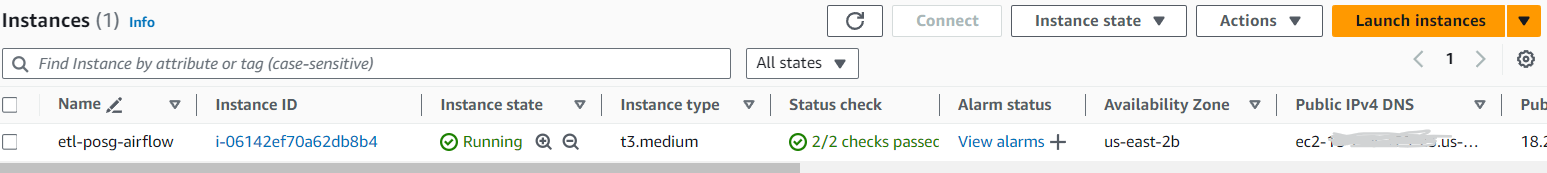

In [6]:
# Instancia implementada en ec2 ubuntu de AWS
# AWS ec2 Ubuntu instance  

Image(filename='EC2.png', width=5000) 

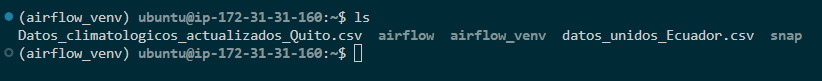

In [12]:
# Running EC2 instance  

Image(filename='ec2_run.png', width=1000) 

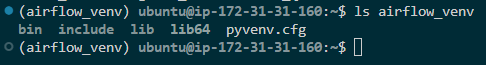

In [14]:
# Running EC2 instance  

Image(filename='ec2_run_1.png', width=800) 

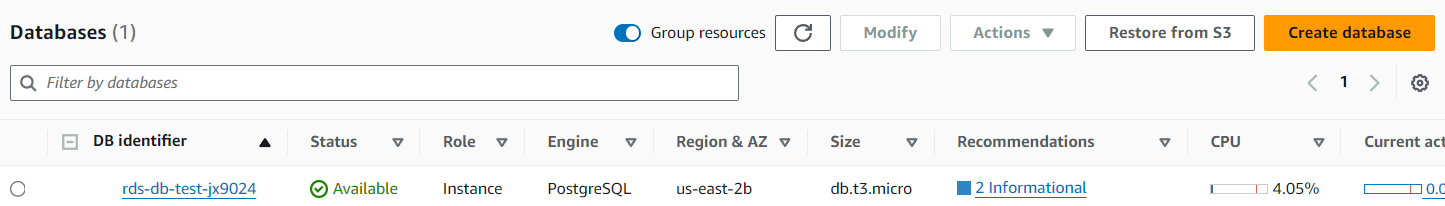

In [15]:
# Running PostgreSQL instance  

Image(filename='rds.png', width=5000) 

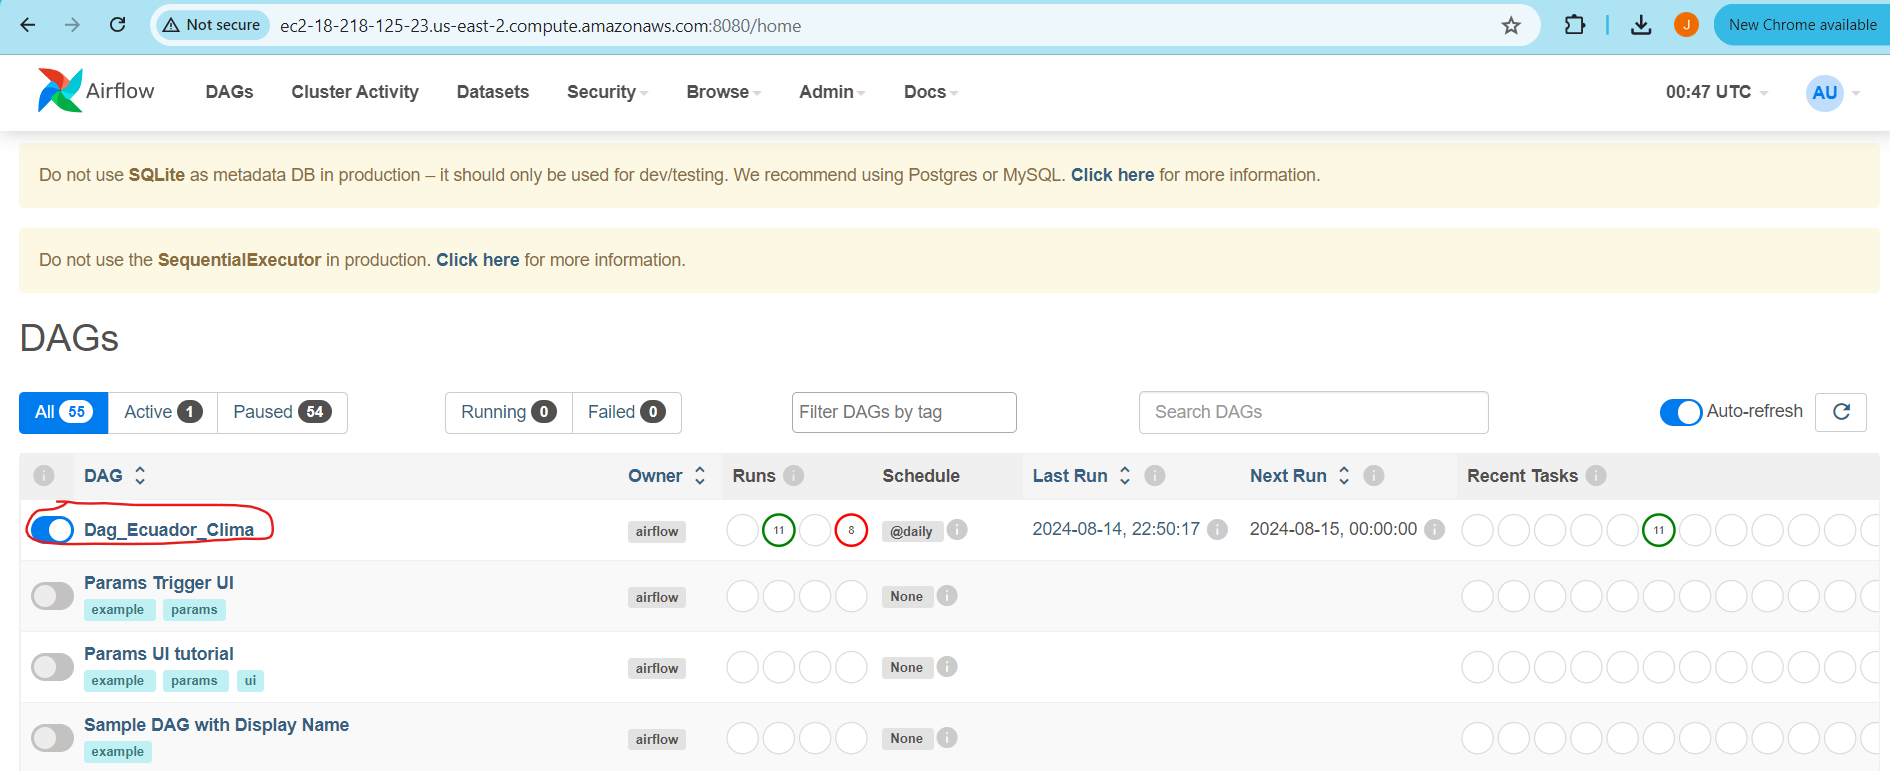

In [26]:
# Airflow DAG Dashboards

Image(filename='Airflow.png', width=3000)

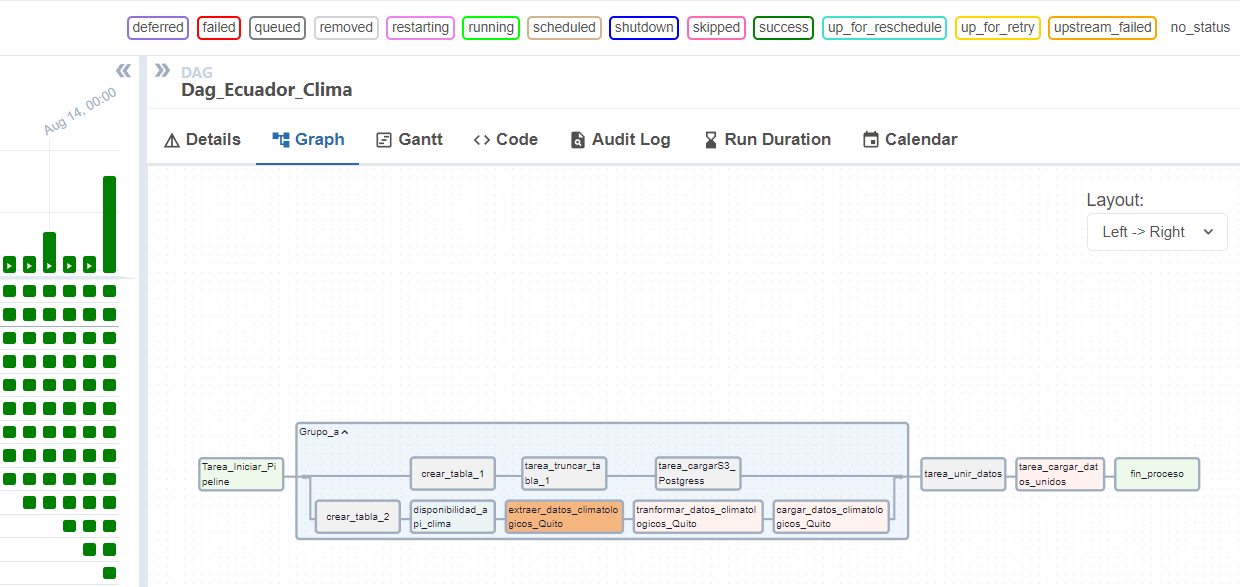

In [27]:
# Airflow DAG_Ecuador_Clima

Image(filename='Airflow_1.png', width=3000)

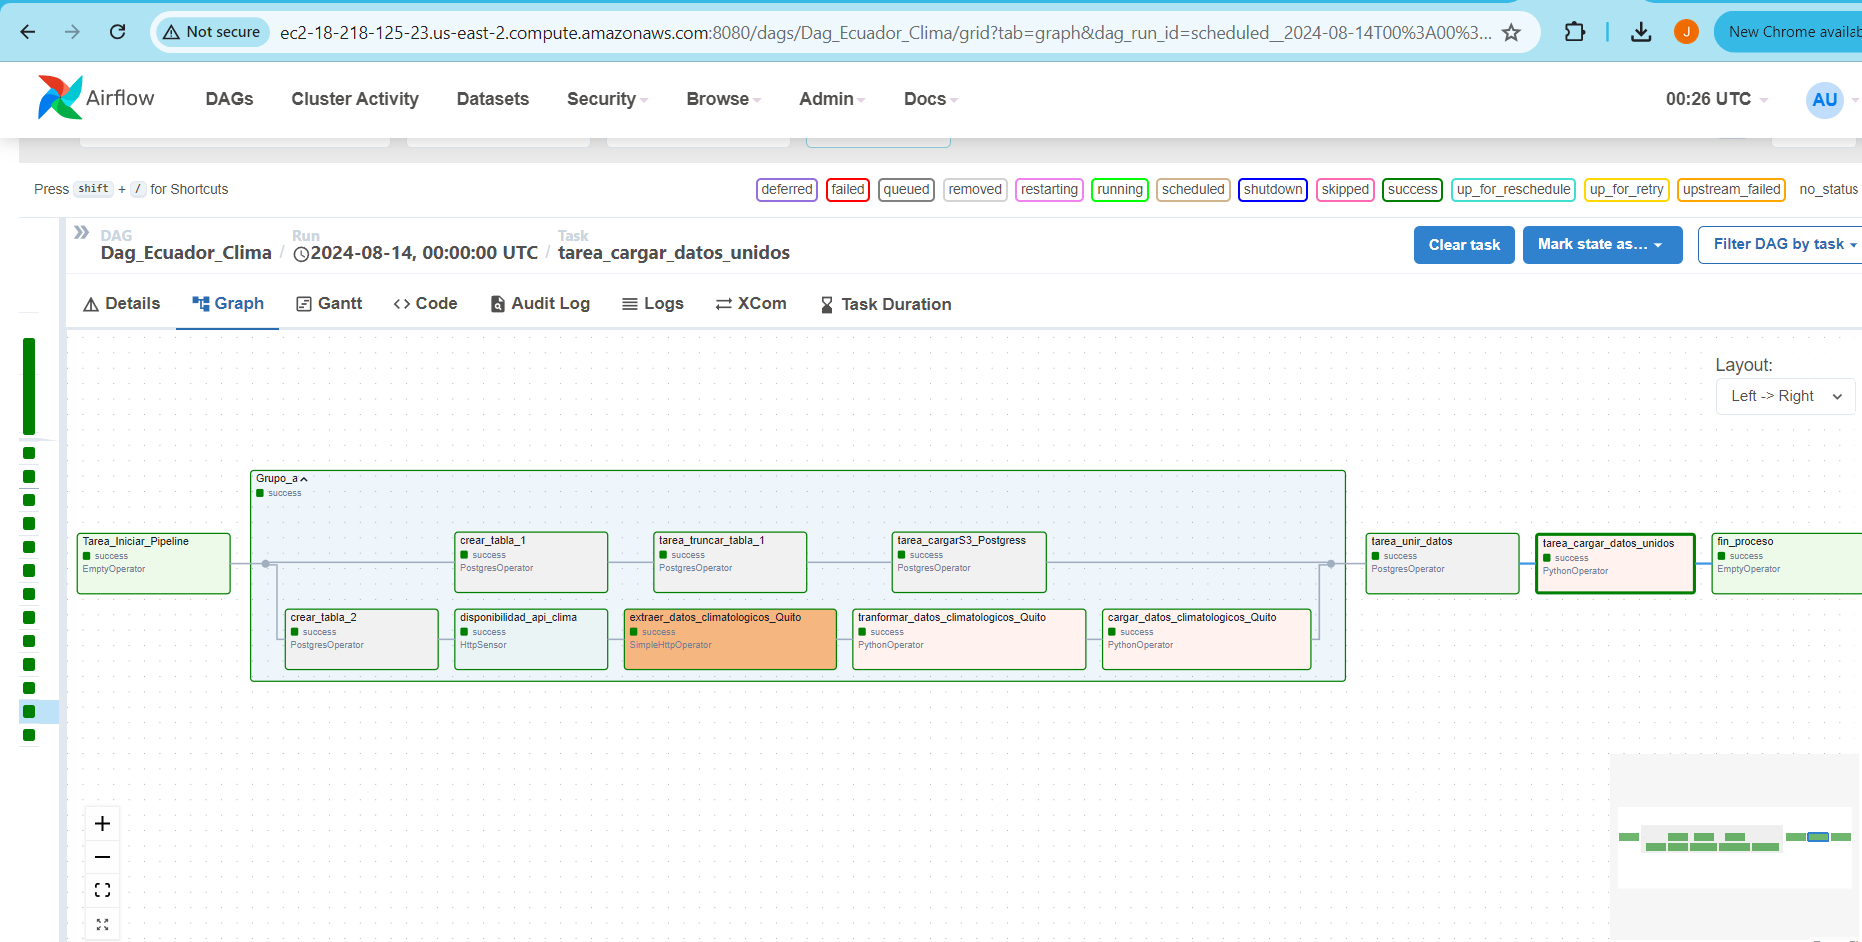

In [28]:
# Airflow DAG_Ecuador_Clima

Image(filename='DAG_Completo.png', width=3000)

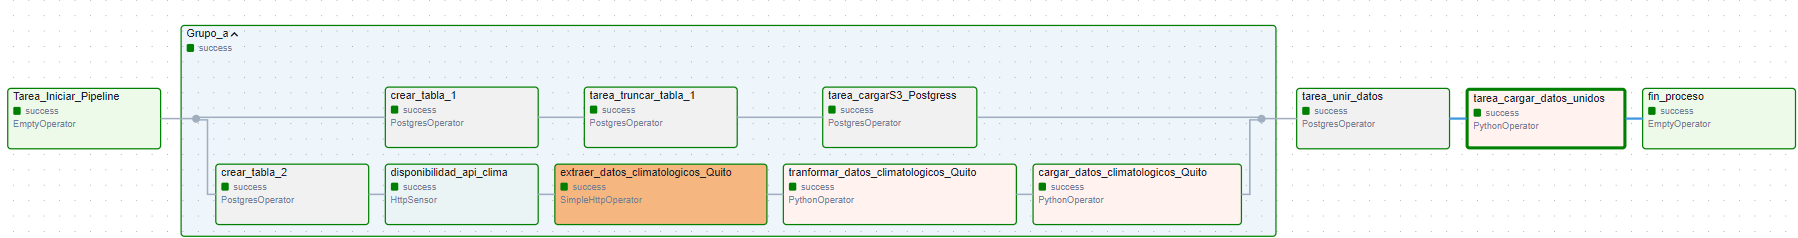

In [30]:
# Airflow DAG_Ecuador_Clima

Image(filename='DAG1.png', width=3000)

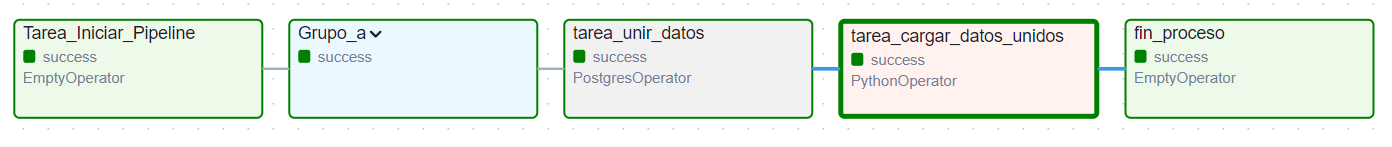

In [31]:
# Airflow DAG_Ecuador_Clima

Image(filename='DAG2.png', width=3000)

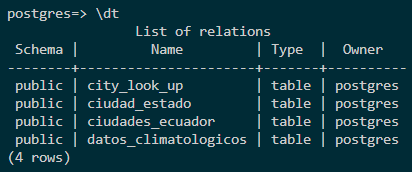

In [53]:
# Displaying Postgres Tables  

Image(filename='Tablas_Postg.png', width=800) 

In [33]:
# Displaying Postgres Query on humedad < 70

Image(filename='post_select_hum.png', width=1000) 

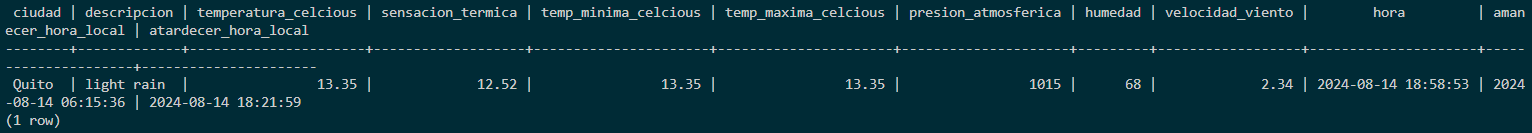

In [52]:
# Displaying Postgres Query Result  

Image(filename='query_humd.png', width=2000) 

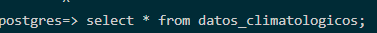

In [35]:
# Displaying all collected data in a 90 minute interval  

Image(filename='Select_code_all.png', width=800) 

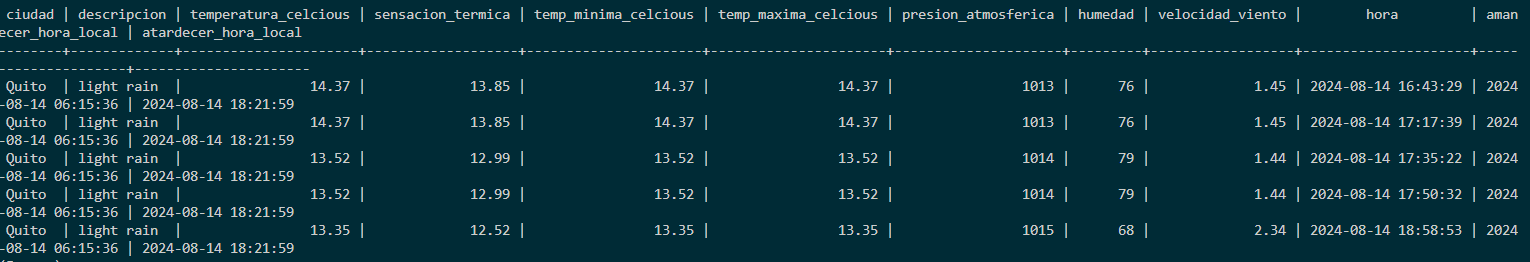

In [36]:
# Displaying all collected data in a 90 minute interval  

Image(filename='Select_dts_clim.png', width=3000) 

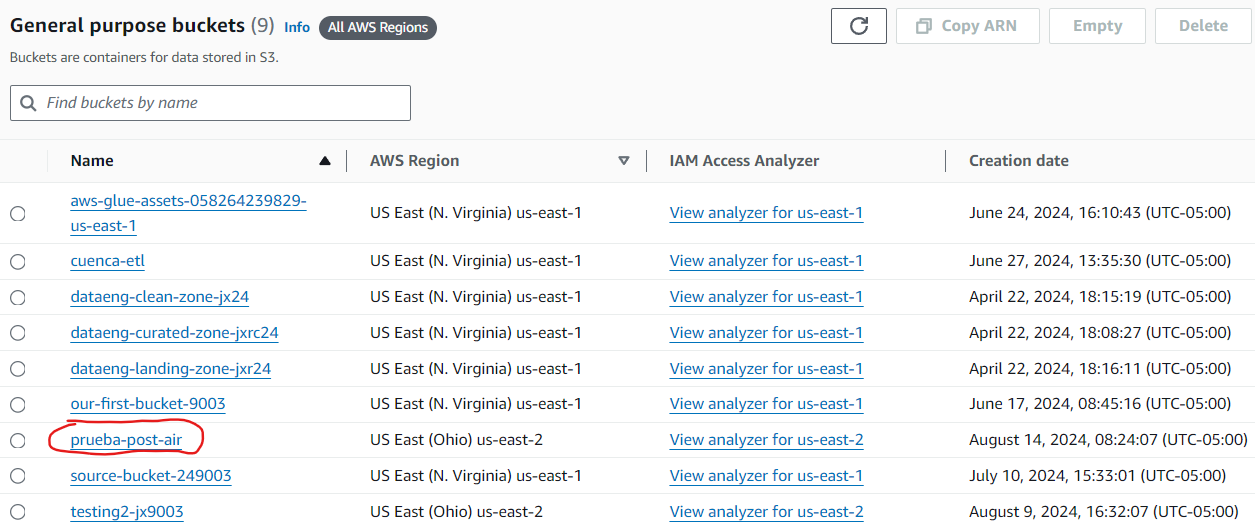

In [47]:
# S3 Buckets

Image(filename='S3_1.png', width=1000)

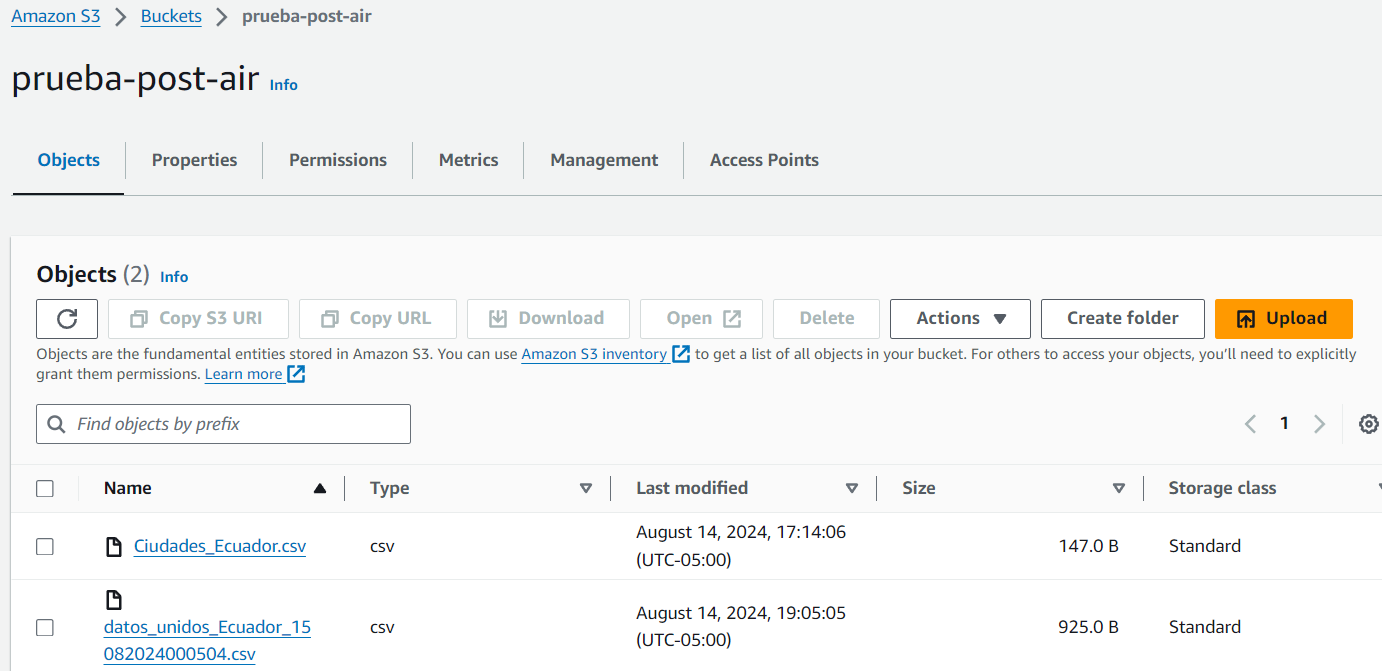

In [46]:
# S3 prueba-post-air bucket verifying loaded csv files

Image(filename='S3.png', width=1000)

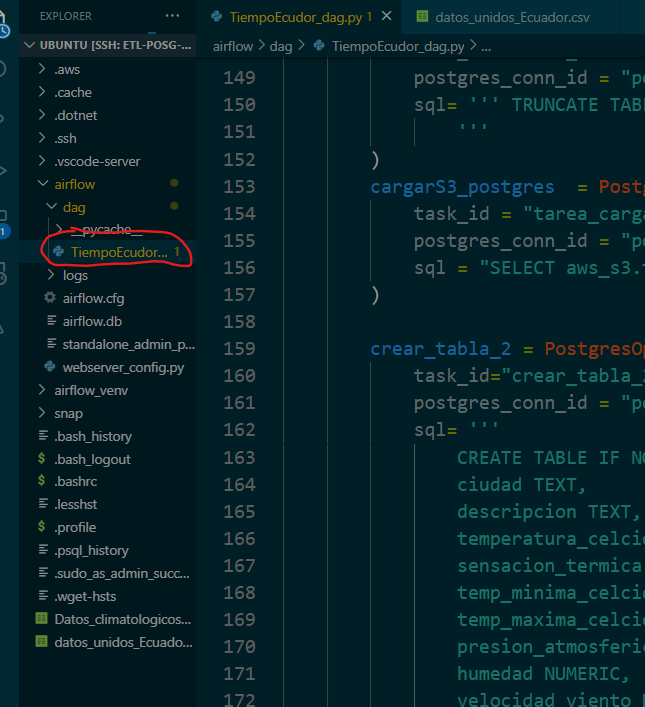

In [43]:
# Coding in Visual Studio Code using an SSH conection to the aws ubuntu ec2 instance

Image(filename='VSC.png', width=500)

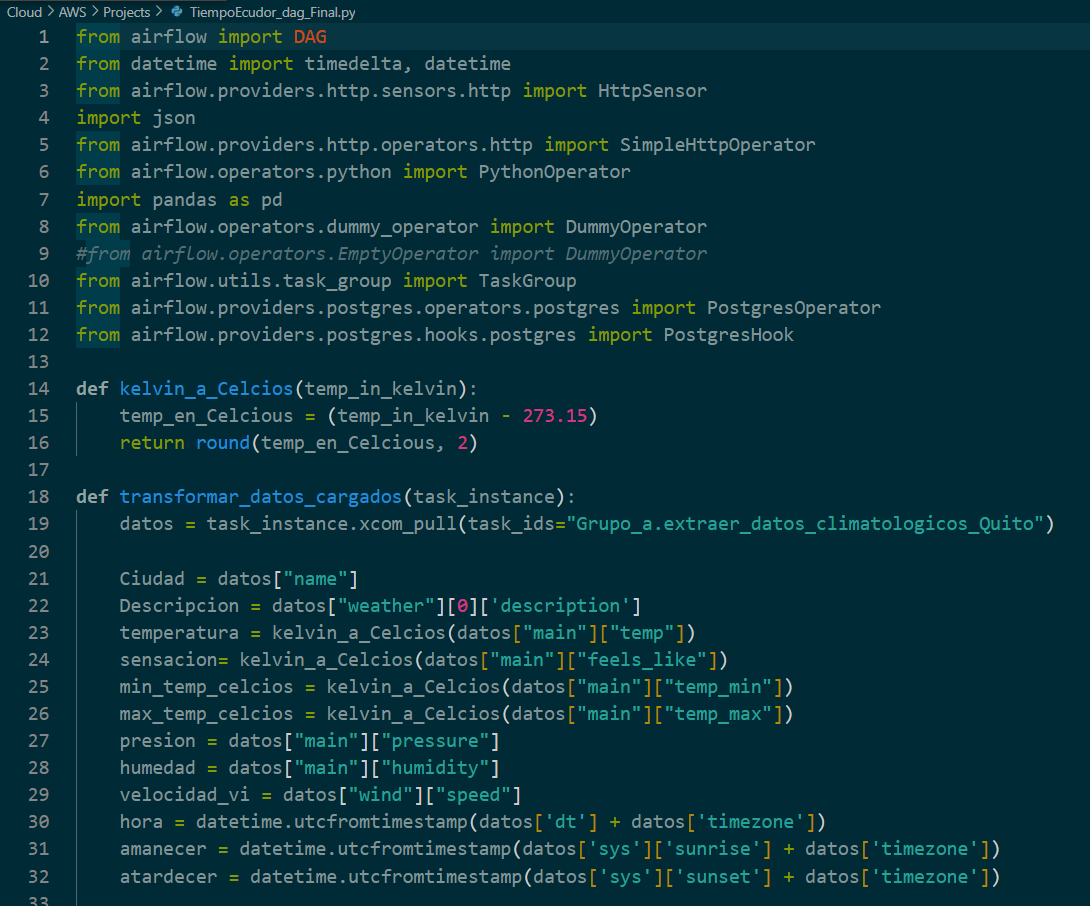

In [45]:
# Coding in Visual Studio Code using an SSH conection to the aws ubuntu ec2 instance

Image(filename='VS_1.png', width=800)